# cluster isolation

## references

[*Quantitative measures of cluster quality for use in extracellular recordings*, Schmitzer-Torbert et al. 2005](https://doi.org/10.1016/j.neuroscience.2004.09.066)

c.f.
* relectro package implementation
    * `relectro/man/isolationDistance-methods.Rd`
    * `relectro/R/SpikeTrain.R`

* spikeA implementation for previous publication
    * `Jazi_et.al_2023_noInt/ExtDataFig11/ExtendedData_fig11.ipynb`
    
https://spikeinterface.readthedocs.io/en/stable/modules/qualitymetrics/isolation_distance.html

## load spikeA session

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

from spikeA.Session import *
from spikeA.Spike_train_loader import Spike_train_loader
from spikeA.Cell_group import Cell_group
from spikeA.Animal_pose import Animal_pose
from spikeA.Session import Session
from spikeA.Intervals import Intervals

In [2]:
path,name = "/adata/electro/pk4926/pk4926-26042024-0101", "pk4926-26042024-0101"

In [3]:
ses = Kilosort_session(name=name, path=path)
ses.load_parameters_from_files()
print(ses)

<class 'spikeA.Session.Kilosort_session'>
name = pk4926-26042024-0101
path = /adata/electro/pk4926/pk4926-26042024-0101
subject = pk4926
session_dat_time = 2024-04-26 01:01:00
fileBase = /adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101
file_names = {'par': '/adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101.par', 'desen': '/adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101.desen', 'desel': '/adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101.desel', 'sampling_rate': '/adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101.sampling_rate_dat', 'stimulation': '/adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101.stimulation', 'px_per_cm': '/adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101.px_per_cm', 'setup': '/adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101.setup', 'environmentFamiliarity': '/adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101.environmentFamiliarity', 'params':

In [4]:
stl = Spike_train_loader()
stl.load_spike_train_kilosort(ses)
print("stl.clu_ids",stl.clu_ids)
cg = Cell_group(stl)
len(cg.neuron_list)

stl.clu_ids [  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  19
  20  21  23  26  27  28  29  31  32  35  36  37  38  39  40  41  42  43
  44  46  47  48  49  50  51  52  53  54  55  57  58  59  61  62  63  64
  65  66  68  69  70  71  72  73  75  76  77  80  81  82  83  84  85  86
  87  88  89  92  93  94  96  97  98  99 100 101 102 104 105 107 108 109
 110 111 112 113 115 116 117 118 119 120 121 122 123 124 126 127 129 130]


108

## calculate isolation distance

In [5]:
cg.set_info_from_session(ses,1)

In [6]:
from scipy.spatial import distance
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html

In [7]:
# get all clusters on same shank as this cell

# 1. get shank for neuron
def get_shank(n):
    shanks_arr, active_shanks, electrodes = ses.get_active_shanks(n.channels)
    shank = active_shanks[0]
    return shank

# 2. get clusters on that shank
def clusters_on_shank(shank):
    cluOnshk = []
    for i,n in enumerate(cg.neuron_list):
        shanks_arr, active_shanks, electrodes = ses.get_active_shanks(n.channels)
        if shank in active_shanks:
            cluOnshk.append(n.cluster_number)
    return cluOnshk


In [8]:
# load pc features
pcf = np.load(ses.path+'/pc_features.npy') ## [nSpikes, nFeaturesPerChannel, nPCFeatures] single
pcf.shape

(1772250, 3, 32)

In [9]:
ses.sc.shape # spike cluster assignment

(1772250,)

In [45]:
# some example neuron
n = cg.neuron_list[0]
n.name, n.cluster_number

('5', 5)

In [46]:
shank = int(get_shank(n))
cluOnshk = clusters_on_shank(shank)
print("neuron is active on shank {} and so many clusters are on that shank too: {}".format(shank,len(cluOnshk)))

neuron is active on shank 1 and so many clusters are on that shank too: 59


In [47]:
ind1 = (ses.sc == n.cluster_number) ### index of the spikes for this clu
pcf_clu1 = pcf[ind1]
pcf_clu1.shape

(7724, 3, 32)

In [48]:
## get the features of the spikes assigned to that cluster
## reshape to get all fet from all channels
pcfClu1 = pcf_clu1.reshape((pcf_clu1.shape[0],pcf_clu1.shape[1]*pcf_clu1.shape[2]))
MeanClu1 = np.mean(pcfClu1, axis = 0)
Covclu1 = np.cov(pcfClu1.T)
pcfClu1.shape, MeanClu1.shape, Covclu1.shape

((7724, 96), (96,), (96, 96))

In [49]:
# loop through all clusters on that shank and get the distance

MedianD=[]
distances=[]
pcf_clus=[] ## pc features for all spikes for all clusters
Id_clus=[] ## cluster number for corresponding pc features

for clu in tqdm(cluOnshk):
    ind = (ses.sc == clu) ### index of the spikes for this clu
    pcf_clu = pcf[ind]
    pcfClu = pcf_clu.reshape((pcf_clu.shape[0],pcf_clu.shape[1]*pcf_clu.shape[2])) ## pc features for all spikes of that clu
    pcf_clus.append(pcfClu)
    Id_clus.append([clu]*len(pcfClu))

    res = np.array([distance.mahalanobis(u,MeanClu1,Covclu1) for u in pcfClu])
    distances.append(np.transpose([res,[clu]*len(res)]))
    MedianD.append(np.median(res))
    #print(np.median(res),clu)


100%|███████████████████████████████████████████| 59/59 [00:40<00:00,  1.44it/s]


In [50]:
distances = np.concatenate(distances)
MedianDneuron = np.median(distances[distances[:,1]==n.cluster_number,0])
pcf_clus = np.concatenate(pcf_clus)
Id_clus = np.concatenate(Id_clus)
distances_sorted = np.array(sorted(distances,key=lambda x:x[0])) # sort by distance, it will start with the spikes within the cluster and have the noise spikes later

ind = distances_sorted[:,1]==n.cluster_number

In [51]:
sum(ind),len(ind) # how many spikes are in the reference cluster, out of total spikes

(7724, 924185)

In [52]:
# calculate the isolation score

ratio = np.cumsum(ind)/(np.arange(len(ind))+1) # spike in reference cluster / spikes within radius
indRatio = ratio<0.5
IsolationScore=np.nan
if np.any(indRatio):
    r=np.arange(len(indRatio))
    indRatio_belowthreshold = np.where([np.all(indRatio[r_:]) for r_ in r])[0]
    if len(indRatio_belowthreshold):
        IsolationScore = distances_sorted[indRatio_belowthreshold[0],0]


In [53]:
MedianDneuron, np.array(MedianD), distances, distances_sorted, IsolationScore, pcf_clus, Id_clus

(22.155372056468398,
 array([35.93003996, 28.78949911, 27.31948892, 73.64715095, 37.17446487,
        22.15537206, 38.30605289, 42.41026284, 34.72062796, 39.47035074,
        40.06671802, 38.57143297, 40.13586693, 39.92741624, 57.74869946,
        42.24835654, 39.89907358, 57.35445555, 39.65062815, 93.11728598,
        75.05148683, 56.02069918, 39.43203478, 86.08671898, 54.19561724,
        39.63116223, 33.2318587 , 44.61266349, 62.07904679, 41.1044739 ,
        62.0212452 , 44.78550228, 39.11938943, 39.49831449, 33.60578137,
        30.64211774, 38.11889026, 42.63995337, 30.41024197, 46.96400579,
        44.56002203, 37.58369776, 39.83138473, 28.96373909, 33.07296082,
        30.09485968, 39.17839932, 32.89455539, 31.89785111, 39.60154356,
        41.01953907, 35.97185347, 36.01755735, 39.96030654, 41.26291371,
        38.20785655, 38.1757566 , 42.56450256, 42.34367608]),
 array([[ 35.7850809 ,   0.        ],
        [ 25.84711413,   0.        ],
        [ 28.04811367,   0.        ],


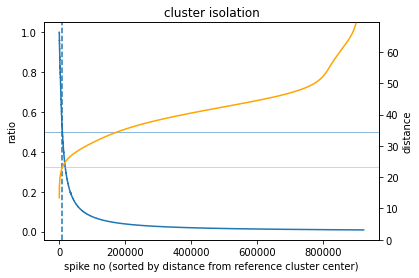

In [54]:
plt.plot(ratio)
plt.ylabel("ratio")
plt.xlabel("spike no (sorted by distance from reference cluster center)")
plt.axhline(y=.5,lw=.5)
plt.axvline(indRatio_belowthreshold[0], ls='dashed')

ax2 = plt.gca().twinx()
ax2.plot(distances_sorted[:,0], c='orange')
plt.axhline(IsolationScore, lw=.5,c='orange')
ax2.set_ylim((0,3*IsolationScore))
ax2.set_ylabel("distance")

plt.title("cluster isolation")
plt.show()

In [55]:
ratio_refclu = np.cumsum(ind)/np.sum(ind) # ratio of how many spikes in reference cluster
ratio_refclu

array([1.29466598e-04, 2.58933195e-04, 3.88399793e-04, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

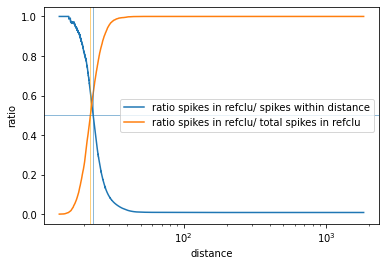

In [56]:
plt.plot(distances_sorted[:,0], ratio, label="ratio spikes in refclu/ spikes within distance")
plt.plot(distances_sorted[:,0], ratio_refclu, label="ratio spikes in refclu/ total spikes in refclu")
plt.gca().set_xscale('log')
plt.axhline(0.5, lw=.5)
plt.axvline(IsolationScore, lw=.5)
plt.axvline(MedianDneuron, lw=.5, c='orange')
plt.xlabel("distance")
plt.ylabel("ratio")
plt.legend()
plt.show()

In [57]:
IsolationScore

23.14728425027978

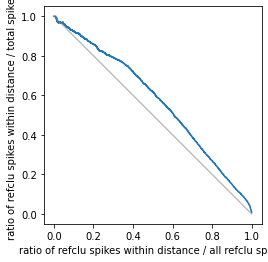

In [61]:
plt.plot(ratio_refclu, ratio)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("ratio of refclu spikes within distance / all refclu spikes")
plt.ylabel("ratio of refclu spikes within distance / total spikes")
plt.plot([0,1],[1,0],c='grey',alpha=.5)
plt.show()